In [23]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

In [25]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [27]:
# Data preprocessing
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [29]:
# Download and load datasets
train_set = datasets.FashionMNIST(root='./data', train=True, download=True, transform=data_transforms)
test_set = datasets.FashionMNIST(root='./data', train=False, download=True, transform=data_transforms)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

In [31]:
# Define CNN with Dropout
class EnhancedCNN(nn.Module):
    def __init__(self):
        super(EnhancedCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model = EnhancedCNN().to(device)

In [33]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.7)

In [35]:
# Training function
def train(model, loader, optimizer, criterion, device, epochs=5):
    model.train()
    best_accuracy = 0
    for epoch in range(epochs):
        epoch_loss = 0
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        scheduler.step()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(loader):.4f}")

In [37]:
# Evaluation function
def evaluate(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    accuracy = (torch.tensor(all_preds) == torch.tensor(all_labels)).float().mean() * 100
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    print(f"Accuracy: {accuracy:.2f}%, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

In [39]:
# Train and evaluate
train(model, train_loader, optimizer, criterion, device)
evaluate(model, test_loader, device)

Epoch 1/5, Loss: 0.5526
Epoch 2/5, Loss: 0.3663
Epoch 3/5, Loss: 0.3105
Epoch 4/5, Loss: 0.2815
Epoch 5/5, Loss: 0.2508
Accuracy: 91.09%, Precision: 0.9104, Recall: 0.9109, F1: 0.9102


In [18]:
# Save model
torch.save(model.state_dict(), "best_cnn_model.pth")
print("Model saved as best_cnn_model.pth")

Model saved as best_cnn_model.pth


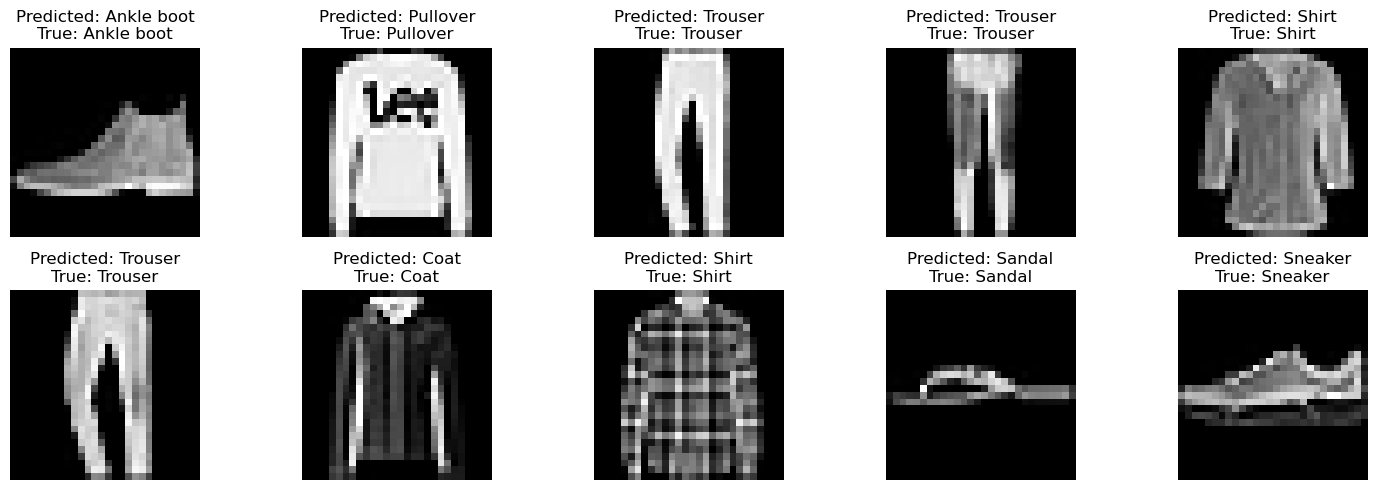

In [21]:
# Function to visualize predictions
def visualize_predictions(model, loader, device, class_names):
    model.eval()
    images, labels = next(iter(loader))
    images, labels = images.to(device), labels.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

    # Convert images back to original format for visualization
    images = images.cpu().numpy().transpose((0, 2, 3, 1))
    images = np.squeeze(images) 
    images = (images * 0.5 + 0.5) * 255 
    
    # Display first 10 predictions
    plt.figure(figsize=(15, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f"Predicted: {class_names[preds[i]]}\nTrue: {class_names[labels[i]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Class labels for FashionMNIST
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# Visualize predictions
visualize_predictions(model, test_loader, device, class_names)
